In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from filterpy.kalman import KalmanFilter

In [2]:
# Load dữ liệu từ file CSV
df = pd.read_csv('CTG.csv', header=0, parse_dates=[0], index_col=0)
df = df[['Price']]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2396\3084941398.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('CTG.csv', header=0, parse_dates=[0], index_col=0)


In [3]:
df = df.dropna()
df = df.reset_index(drop=True)
train_size = int(0.7 * len(df))
test_size = int(0.1 * len(df))
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [4]:
#kf = KalmanFilter(dim_x=1, dim_z=1)  # State dimension and observation dimension
#kf.H = np.array([[1]])  # Observation matrix (observe price directly)
#kf.P = np.array([[1]])  # Initial state covariance
#kf.R = np.array([[1]])  # Observation covariance
#kf.Q = np.array([[0.01]])  # Transition covariance (adjust as needed)

# Introduce a drift term (0.001 here, adjust as needed) to allow for gradual price changes
#kf.F = np.array([[1.001]])
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.F = np.array([[1, 1], [0, 1]])  # ma trận trạng thái
kf.H = np.array([[1, 0]])          # ma trận quan sát
kf.Q = np.array([[0.001, 0], [0, 0.001]])  # ma trận nhiễu quá trình
kf.R = np.array([[0.1]])           # ma trận nhiễu quan sát
kf.P *= 1000       

In [5]:
filtered_train_state_means = []
for price in train_data['Price'].values:
    kf.predict()
    kf.update(np.array([[price]]))
    filtered_train_state_means.append(kf.x[0][0])

In [6]:
filtered_test_state_means = []
predictions = []
for price in test_data['Price'].values:
    kf.predict()
    kf.update(np.array([[price]]))
    filtered_test_state_means.append(kf.x[0][0])
    predictions.append(kf.x[0][0])

predictions_30_days = []
for _ in range(30):
    kf.predict()
    predictions_30_days.append(kf.x[0][0])

In [7]:
test_rmse = np.sqrt(np.mean((predictions - test_data['Price'].values)**2))
test_mape = np.mean(np.abs((predictions - test_data['Price'].values) / test_data['Price'].values)) * 100
test_mae = np.mean(np.abs(predictions - test_data['Price'].values))
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 675.8481550406306
Testing MAPE: 1.598518126146034
Testing MAE: 502.12847339528565


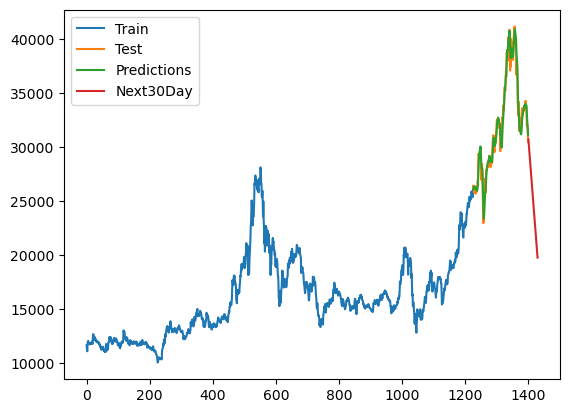

In [8]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, predictions)

# Use the last index of the test data to start the 30-day prediction plot
plt.plot(range(test_data.index[-1] + 1, test_data.index[-1] + 31), predictions_30_days)

plt.legend(['Train', 'Test', 'Predictions', 'Next30Day'])
plt.show()